# 训练思路

Logic：仅预测撂荒地上光伏建设概率即可，加入多时序可以丰富样本信息、学习到增量样本表示

数据流：


输入：
1、训练样本（划分训练集、测试集合）：美国光伏正样本；
2、预测样本：美国光伏用地；

输出：得到

数据操作：

（先用QQ图观察各个数据的分布特征）对于符合正态分布特征可以直接进入聚类；

1、样本标准化；
2、


后期数据补齐（后期模型优化需要注意的point）
1、Y数据源统一的问题；
2、R语言包问题解决；d
3、提取光伏Y=1正标签对应的landcover序列

# Load Data

In [31]:
from function import *
import pandas as pd
import pandas as pd
import geopandas as gpd
from typing import Sequence



abandon_2d_variable = [
    "current_abandonment",
    "recultivation", 
    "abandonment_duration",
    "abandonment_year"
]
fea_3d_variable = [
    'GDPpc',
    'GDPtot',
    'GURdist',
    'Population',
    'gdmp',
    'rsds',
    'tas',
    'wind'
]
fea_2d_variable = [
    'DEM',
    'Powerdist',
    'PrimaryRoad',
    'SecondaryRoad',
    'Slope',
    'TertiaryRoad'
]
PATHS = {
    'abandonment': r"D:\xarray\merged_chunk_2\*.nc",
    'feature':     "D:/xarray/aligned2/Feature_all/*.nc",
    'csv':         "aligned_for_training0519.csv",
    'prediction':  "",
    'prediction_us': "",
    'test_output': "positive_samples_test_500.csv",
    'output':      "positive_samples_full_with_features.csv",
    'CN_sheng': r'data\sheng2022.shp',
    'World_shp': r'data\main_ADM_0.shp', 
    'us_abandon': r'data\us_abandon_clean.csv',
    'us_pv_embedding': r'data\training_embedding.csv'
}

ZERO_COLS = [
     'GDPpc', 'GDPtot', 'GURdist', 'Population',
    'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'gdmp'
]
YEARS = [2018, 2020]

NUMERIC_FEATURES = [
    'lat','lon','GDPpc', 'GDPtot', 'GURdist', 'DEM','Slope',
    'Population','Powerdist','PrimaryRoad','SecondaryRoad','TertiaryRoad',
    'gdmp','rsds','tas','wind'
]
CAT_COLS = ['landcover']

ABANDON_COLS = ['abandonment_year','abandonment_duration', 'current_abandonment']

NONE_ABANDON_COLS = ['recultivation']

time=['2018-01-01','2020-01-01']







# 一阶段相似性建模

## 数据检查

In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import (
    FunctionTransformer, QuantileTransformer,
    StandardScaler, MinMaxScaler, RobustScaler,
    OneHotEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from function.data_utils import NUMERIC_FEATURES, CAT_COLS, ZERO_COLS, ABANDON_COLS, NONE_ABANDON_COLS
from function import *
import matplotlib.pyplot as plt


def check_transformed_data(X_trans, preproc, df_pos, feature_groups):
    """
    检查转换后的数据质量
    
    Args:
        X_trans: 转换后的数据
        preproc: ColumnTransformer对象
        df_pos: 原始数据
        feature_groups: 特征分组字典
    """
    # print("1. 基本检查:")
    # print("  - 包含NaN:", np.isnan(X_trans).any())
    # print("  - 包含inf:", np.isinf(X_trans).any())
    # print("  - Shape:", X_trans.shape)
    
    # print("\n2. 数值统计:")
    # print("  - 最小值:", X_trans.min())
    # print("  - 最大值:", X_trans.max())
    # print("  - 均值:", X_trans.mean())
    # print("  - 标准差:", X_trans.std())
    
    # 检查每个特征组的转换结果
    print("\n3. 特征组统计:")
    start_idx = 0
    for name, features in feature_groups.items():
        if name == 'cat_features':
            # 对于类别特征，需要计算OneHotEncoder的输出特征数
            n_features = len(np.unique(df_pos[features].values))
        else:
            n_features = len(features)
            
        group_data = X_trans[:, start_idx:start_idx + n_features]
        print(f"\n{name}特征组:")
        print(f"  - Shape: {group_data.shape}")
        print(f"  - 取值范围: [{group_data.min():.3f}, {group_data.max():.3f}]")
        print(f"  - 均值: {group_data.mean():.3f}")
        print(f"  - 标准差: {group_data.std():.3f}")
        start_idx += n_features
    
    return X_trans

## KDE模型

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (
    FunctionTransformer, QuantileTransformer,
    RobustScaler, StandardScaler, MinMaxScaler,
    OneHotEncoder
)
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

# ==============================
# 辅助函数
# ==============================

def safe_log1p(x, lower_bound=-1 + 1e-6):
    """
    对 x 做 log1p 前，确保 x > lower_bound
    """
    arr = np.array(x, dtype=float)
    arr = np.where(arr <= lower_bound, lower_bound, arr)
    return np.log1p(arr)


def replace_inf_with_nan(X):
    """
    将数组中的 ±Inf 替换为 NaN，方便后续填充
    """
    X = np.array(X, dtype=float)
    X[~np.isfinite(X)] = np.nan
    return X

# ==============================
# 1. KDE 模型训练函数
# ==============================

def select_and_train_kde(df_pos: pd.DataFrame, bandwidths: list = None):
    """
    选择和训练KDE模型。
    """
    # 特征分组
    LOG = ['GDPpc', 'GDPtot', 'Population', 'Powerdist']
    DEM_SLOPE = ['DEM', 'Slope']
    DIST = ['GURdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad']
    NORMAL = ['tas', 'gdmp', 'rsds', 'wind']
    # GEO = ['lat', 'lon']
    CAT = CAT_COLS.copy()

    # 数值特征流水线保持不变
    log_pipe = make_pipeline(
        FunctionTransformer(replace_inf_with_nan),
        SimpleImputer(strategy='median'),
        FunctionTransformer(lambda X: safe_log1p(X), validate=False),
        QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=0)
    )

    dem_slope_pipe = make_pipeline(
        FunctionTransformer(replace_inf_with_nan),
        SimpleImputer(strategy='median'),
        FunctionTransformer(lambda X: safe_log1p(X - X.min(axis=0) + 1e-6), validate=False),
        QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=0)
    )

    dist_pipe = make_pipeline(
        FunctionTransformer(replace_inf_with_nan),
        SimpleImputer(strategy='median'),
        FunctionTransformer(lambda X: safe_log1p(X), validate=False),
        RobustScaler()
    )

    normal_pipe = make_pipeline(
        SimpleImputer(strategy='median'),
        StandardScaler()
    )

    # geo_pipe = make_pipeline(
    #     SimpleImputer(strategy='median'),
    #     MinMaxScaler()
    # )

    # 修改类别特征处理流水线
    cat_pipe = make_pipeline(
        SimpleImputer(strategy='most_frequent'),  # 使用最频繁值填充
        OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    )

    # 整体预处理器
    preproc = make_column_transformer(
        (log_pipe, LOG),
        (dem_slope_pipe, DEM_SLOPE),
        (dist_pipe, DIST),
        (normal_pipe, NORMAL),
        # (geo_pipe, GEO),
        (cat_pipe, CAT),
        remainder='drop'
    )

    # 构建Pipeline
    full_pipe = Pipeline([
        ('preprocessor', preproc),
        ('kde', KernelDensity(kernel='gaussian', atol=1e-8, rtol=1e-4))
    ])

    # 带宽候选
    if bandwidths is None:
        bandwidths = np.logspace(-2, -1, 20)

    # 网格搜索带宽
    grid = GridSearchCV(
        estimator=full_pipe,
        param_grid={'kde__bandwidth': bandwidths},
        cv=5,
        n_jobs=-1
    )
    
    # 添加错误处理
    try:
        grid.fit(df_pos)
    except Exception as e:
        print("训练过程中出现错误:")
        print(e)
        # 打印输入数据的信息以帮助调试
        print("\n输入数据信息:")
        print("形状:", df_pos.shape)
        print("\n特征类型:")
        print(df_pos.dtypes)
        print("\n是否有缺失值:")
        print(df_pos.isna().sum())
        raise

    # 输出最佳结果
    best_bw = grid.best_params_['kde__bandwidth']
    print(f"最佳带宽: {best_bw}")
    print(f"最佳平均对数似然: {grid.best_score_:.3f}")
    print("\n各候选带宽的平均对数似然：")
    for bw, score in zip(grid.cv_results_['param_kde__bandwidth'], 
                        grid.cv_results_['mean_test_score']):
        print(f"  h={bw:.4g} → log-lik={score:.3f}")

    return grid.best_estimator_

# ==============================
# 2. 环境得分函数
# ==============================

def score_env(kde_pipeline: Pipeline, df_query: pd.DataFrame,
              method: str = 'sigmoid', sigmoid_alpha: float = None):
    """
    使用训练好的 KDE Pipeline 计算环境相似度得分

    Args:
        kde_pipeline: 已拟合的 Pipeline (preprocessor + kde)
        df_query: pandas.DataFrame, 查询样本
        method: str, 'minmax', 'quantile', 'zscore' 或 'sigmoid'
        sigmoid_alpha: float or None, sigmoid 拉伸系数，None 则自动计算

    Returns:
        dens: np.ndarray, 原始密度值
        scores: np.ndarray, [0,1] 归一化分数
    """
    # 计算原始对数密度与密度
    logdens = kde_pipeline.score_samples(df_query)
    dens = np.exp(logdens)

    # 归一化方法选择
    if method == 'minmax':
        scores = (logdens - logdens.min()) / (logdens.max() - logdens.min())
    elif method == 'quantile':
        qt = QuantileTransformer(output_distribution='uniform',
                                 n_quantiles=min(1000, len(logdens)), random_state=0)
        scores = qt.fit_transform(logdens.reshape(-1,1)).ravel()
    elif method == 'zscore':
        z = (logdens - logdens.mean()) / logdens.std()
        scores = (z - z.min()) / (z.max() - z.min())
    elif method == 'sigmoid':
        beta = np.median(logdens)
        if sigmoid_alpha is None:
            # 令 logistic(±range/2) ~ [0.05,0.95]
            rng = logdens.max() - logdens.min()
            sigmoid_alpha = (2 * np.log(19)) / rng
        scores = 1 / (1 + np.exp(-sigmoid_alpha * (logdens - beta)))
    else:
        raise ValueError("method must be 'minmax', 'quantile', 'zscore', or 'sigmoid'")

    return dens, scores


# ==============================
# 3. 可选的数据检查函数
# ==============================

def inspect_kde_data(df_train, df_test, feature_names):
    print("训练集形状:", df_train.shape)
    print("测试集形状:", df_test.shape)
    fig, axes = plt.subplots(len(feature_names), 2, figsize=(15, 4*len(feature_names)))
    for i, feat in enumerate(feature_names):
        axes[i,0].hist(df_train[feat], bins=30, alpha=0.5); axes[i,0].set_title(f'Train: {feat}')
        axes[i,1].hist(df_test[feat],  bins=30, alpha=0.5); axes[i,1].set_title(f'Test:  {feat}')
    plt.tight_layout(); plt.show()
    print("\n训练集统计:"); print(df_train.describe())
    print("\n测试集统计:"); print(df_test.describe())


## 相似性评分

In [24]:
def score_env(kde_pipeline: Pipeline, df_query: pd.DataFrame) :
    """
    使用训练好的KDE模型计算环境相似度得分
    
    Args:
        kde_pipeline: 训练好的KDE Pipeline，包含预处理器和KDE模型
        df_query: 需要计算得分的查询数据集
    
    Returns:
        Tuple[np.ndarray, np.ndarray]: 
            - 密度值
            - 标准化后的环境得分（0-1之间）
    """
    # 1. 使用pipeline进行预处理和密度估计
    log_dens = kde_pipeline.score_samples(df_query)
    
    # 2. 将对数密度转换为密度值
    dens = np.exp(log_dens)
    
    # 3. 将密度值归一化到0-1之间作为环境得分
    env_scores = (dens - dens.min()) / (dens.max() - dens.min())
    
    return dens, env_scores

# 二阶段模型

## 第二阶段端正样本准备与标签构建

In [12]:


def prepare_stage2(df_embedding: pd.DataFrame,
                   df_abandon_filtered: pd.DataFrame,
                   env_scores: np.ndarray,
                   include_negatives: bool = True):
    """
    构建阶段 2 训练集：
      - 正样本: df_embedding, label=1, env_score=1.0
      - 负样本 (可选): df_abandon_filtered[current_abandonment==0], label=0, env_score 对应
    废弃列统一填 NaN→-1，并添加 _miss 指示器。
    返回:
      df_stage2: DataFrame with columns [
        'env_score',
        'abandonment_year','abandonment_year_miss',
        'abandonment_duration','abandonment_duration_miss',
        'label'
      ]
      unlabeled_idx: 原 df_abandon_filtered 中 current_abandonment==1 的行索引 (用于映射预测)
    """
    # 1) 找到待预测子集并记录原始索引
    mask_unlabeled = df_abandon_filtered['current_abandonment'] == 1
    unlabeled_idx = df_abandon_filtered.index[mask_unlabeled]

    # env_scores 与 df_abandon_filtered 行一一对应
    env_unlabeled = env_scores[mask_unlabeled.values]
    env_neg = env_scores[~mask_unlabeled.values]

    # 2) 构造正样本
    df_pos = df_embedding.copy().reset_index(drop=True)
    df_pos['env_score'] = 1.0
    for col in ['abandonment_year','abandonment_duration']:
        df_pos[f'{col}_miss'] = df_pos[col].isna().astype(int)
        df_pos[col] = df_pos[col].fillna(-1)

    # 3) 构造负样本（可选）
    if include_negatives:
        df_neg = df_abandon_filtered[~mask_unlabeled].copy().reset_index(drop=True)
        df_neg['env_score'] = env_neg
        for col in ['abandonment_year','abandonment_duration']:
            df_neg[f'{col}_miss'] = df_neg[col].isna().astype(int)
            df_neg[col] = df_neg[col].fillna(-1)
        df_stage2 = pd.concat([
            df_pos.assign(label=1),
            df_neg.assign(label=0)
        ], ignore_index=True)
    else:
        df_stage2 = df_pos.assign(label=1)

    return df_stage2, unlabeled_idx

# 模型训练

You want to predict the year: 2020.0
最佳带宽: 0.30538555088334157
最佳平均对数似然: -30819.841

各候选带宽的平均对数似然：
  h=0.001 → log-lik=-1465501363.970
  h=0.00115 → log-lik=-1110207332.766
  h=0.001322 → log-lik=-850860595.179
  h=0.00152 → log-lik=-646434614.606
  h=0.001748 → log-lik=-494701212.959
  h=0.002009 → log-lik=-378256834.409
  h=0.00231 → log-lik=-286782211.890
  h=0.002656 → log-lik=-220345847.119
  h=0.003054 → log-lik=-168774620.106
  h=0.003511 → log-lik=-130127591.652
  h=0.004037 → log-lik=-100092485.993
  h=0.004642 → log-lik=-75896858.753
  h=0.005337 → log-lik=-57467654.384
  h=0.006136 → log-lik=-43337874.653
  h=0.007055 → log-lik=-33190079.560
  h=0.008111 → log-lik=-25013349.782
  h=0.009326 → log-lik=-19196150.045
  h=0.01072 → log-lik=-14512694.640
  h=0.01233 → log-lik=-11055101.872
  h=0.01417 → log-lik=-8400598.196
  h=0.0163 → log-lik=-6250932.346
  h=0.01874 → log-lik=-4553028.306
  h=0.02154 → log-lik=-3370724.057
  h=0.02477 → log-lik=-2444195.853
  h=0.02848 → log-l

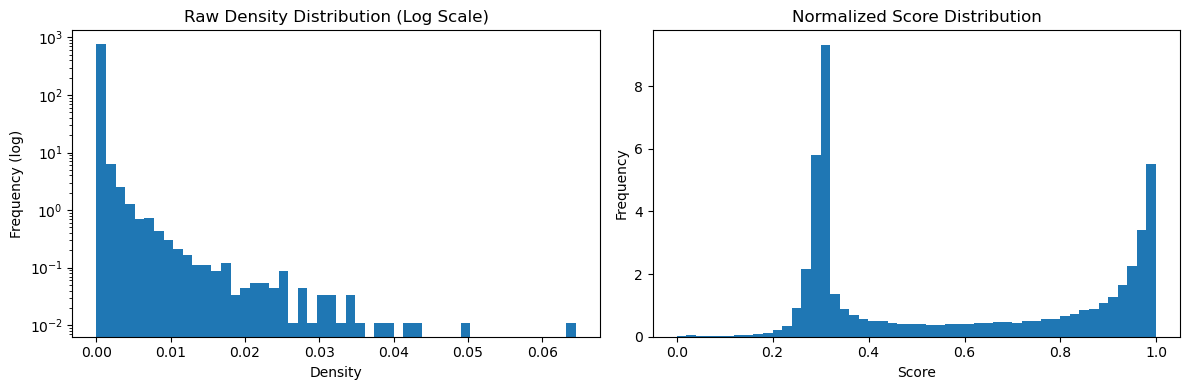

In [46]:
from function import *

if __name__ == '__main__':
    usa_bounds_main = {
        'lon_min': -125,  # 美国本土最西端（华盛顿州）
        'lon_max': -65,   # 美国本土最东端（缅因州）
        'lat_min': 25,    # 美国本土最南端（佛罗里达州）
        'lat_max': 49     # 美国本土最北端（与加拿大接壤）
    }
       
    # 加载数据
    df_abandon = load_abandon(PATHS['us_abandon'])
    df_embedding = load_embedding(PATHS['us_pv_embedding'])


    # Filter df_embedding to only include points within USA mainland bounds
    df_embedding = df_embedding[
        (df_embedding['lon'] >= usa_bounds_main['lon_min']) & 
        (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
        (df_embedding['lat'] >= usa_bounds_main['lat_min']) & 
        (df_embedding['lat'] <= usa_bounds_main['lat_max'])
    ]

    # 填充缺失值
    df_abandon_fill = fill_nonpositive_with_nearest(df_abandon)
    df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)
    
    # 去除重复值
    df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)



    # inspect_kde_data(
    # df_train=df_embedding_fill[NUMERIC_FEATURES + CAT_COLS],
    # df_test=df_abandon_filtered[NUMERIC_FEATURES + CAT_COLS],
    # feature_names=NUMERIC_FEATURES + CAT_COLS)


    # 阶段一建模，使用KDE模型测算相似分数
    features_no_coords = [f for f in NUMERIC_FEATURES + CAT_COLS if f not in ['lat', 'lon']]
    kde_pipe = select_and_train_kde(df_embedding_fill[features_no_coords], bandwidths = np.logspace(-3, 3, 100) )
    dens, env_scores = score_env(kde_pipe, df_abandon_filtered[features_no_coords], 
                           method='sigmoid', 
                           sigmoid_alpha=0.5) 
    # 检查结果分布
    plt.figure(figsize=(12, 4))

    plt.subplot(121)
    plt.hist(dens, bins=50, density=True)
    plt.yscale('log')  # 使用对数刻度更好地显示分布
    plt.title('Raw Density Distribution (Log Scale)')
    plt.xlabel('Density')
    plt.ylabel('Frequency (log)')

    # 归一化后的得分分布
    plt.subplot(122)
    plt.hist(env_scores, bins=50, density=True)
    plt.title('Normalized Score Distribution')
    plt.xlabel('Score')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # # 阶段二构建训练集 & 训练分类器
    # df_stage2, unlabeled_idx = prepare_stage2(
    #     df_embedding=df_embedding,
    #     df_abandon_filtered=df_abandon_filtered,
    #     env_scores=env_scores,
    #     include_negatives=False  # 第一次跑可只用正样本
    # )
    # clf = train_stage2(df_stage2)

    # # 5. 阶段 2：预测
    # final_probs = predict_stage2(clf, df_stage2, unlabeled_idx)

    # # 6. 输出 NetCDF
    # ds = build_final_ds(df_abandon_filtered, final_probs)
    # save_netcdf(ds, 'prediction_2020.nc')



    
    
    

In [39]:
df_embedding_fill[features_no_coords]
df_abandon_filtered[features_no_coords]

,GDPpc,GDPtot,GURdist,DEM,Slope,Population,Powerdist,PrimaryRoad,SecondaryRoad,TertiaryRoad,gdmp,rsds,tas,wind,landcover
0,22847.0,263085.0,625070.90,128.7500,0.922605,11.311211,622572.70,9.479545,2.584110,44.558012,65.551445,20.555853,2981.984506,1.413225,2.0
1,11575.0,83368.0,625070.90,96.3125,4.124147,18.070621,622572.60,7.480710,2.584110,77.081042,76.545799,20.408821,2982.749690,1.381223,2.0
2,22847.0,263085.0,625070.90,176.3750,2.743563,30.985685,622572.70,9.479545,2.584110,51.958872,80.134598,20.785990,2980.215050,1.337188,2.0
3,11575.0,83368.0,625070.90,77.1250,1.319031,18.070620,622572.60,7.480710,2.584110,77.081042,62.175598,20.607885,2983.972465,1.395731,2.0
4,10594.0,6383865.0,625071.56,1730.6250,1.524049,801.546940,622573.30,7.372286,15.512376,217.405949,104.869400,22.585236,2913.419221,1.931024,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70307,29640.0,1235602.0,625062.10,46.5000,2.177264,36.469215,622564.00,15.564339,0.007833,91.230789,70.525002,12.947352,2763.749943,3.296368,3.0
70308,33888.0,1311266.0,625061.06,228.4375,1.650701,37.958690,622562.94,54.122274,0.299834,43.559419,58.398994,13.006569,2756.330329,4.223490,2.0
70309,42697.0,39483.0,625059.50,105.2500,0.152130,3.476491,622561.40,16.693830,1.095873,40.225892,91.527328,12.529724,2756.581936,3.581519,2.0
70310,43202.0,39483.0,625059.50,106.8125,0.207614,2.859361,622561.40,8.394693,1.095873,28.790137,79.406998,12.526788,2756.086073,3.699206,2.0


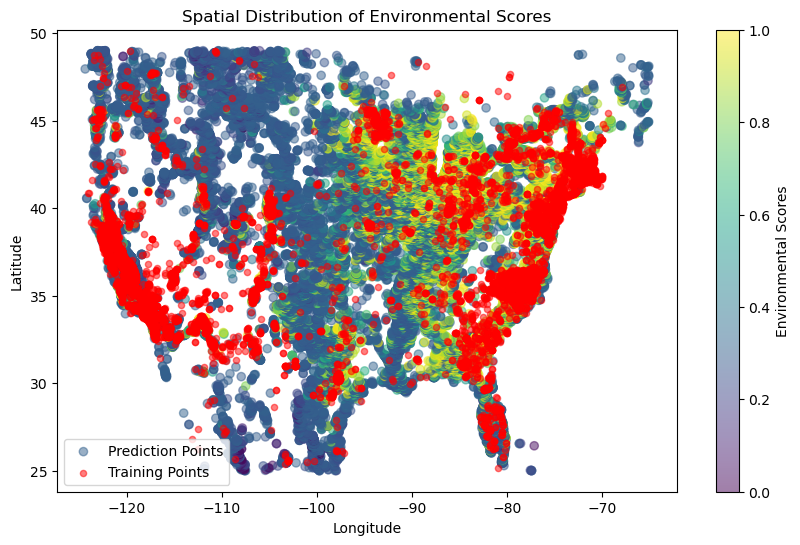

In [47]:
# 将env_scores匹配到原始样本的经纬度上并保存
df_abandon_filtered['env_scores'] = env_scores
# Try saving with different encoding
df_abandon_filtered.to_csv('./data/abandon_filtered_with_scores.csv', index=False)# 绘制地图
plt.figure(figsize=(10,6))

# 绘制待预测点
plt.scatter(df_abandon_filtered['lon'], df_abandon_filtered['lat'], 
           c=df_abandon_filtered['env_scores'], cmap='viridis',
           alpha=0.5, label='Prediction Points')

# 叠加训练样本点
plt.scatter(df_embedding_fill['lon'], df_embedding_fill['lat'],
           color='red', alpha=0.5, s=20, label='Training Points')

plt.colorbar(label='Environmental Scores')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of Environmental Scores')
plt.legend()
plt.show()

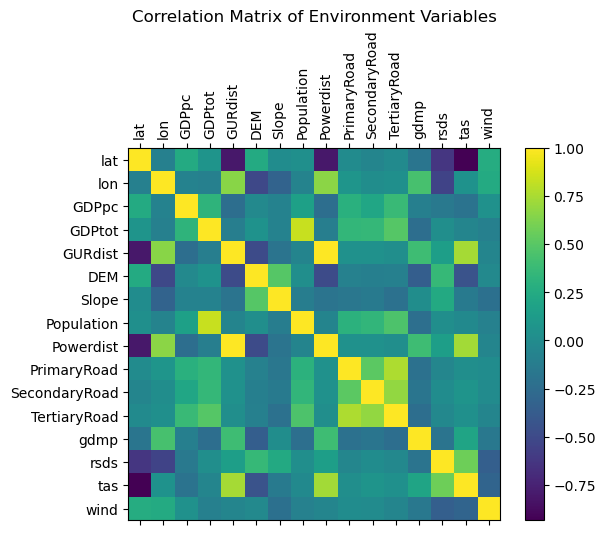

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# 1. 绘制环境变量的相关系数矩阵
env_df = df_abandon_filtered[NUMERIC_FEATURES]
corr = env_df.corr()

plt.figure()
plt.matshow(corr, fignum=1)
plt.xticks(range(len(NUMERIC_FEATURES)), NUMERIC_FEATURES, rotation=90)
plt.yticks(range(len(NUMERIC_FEATURES)), NUMERIC_FEATURES)
plt.title('Correlation Matrix of Environment Variables')
plt.colorbar()
plt.show()

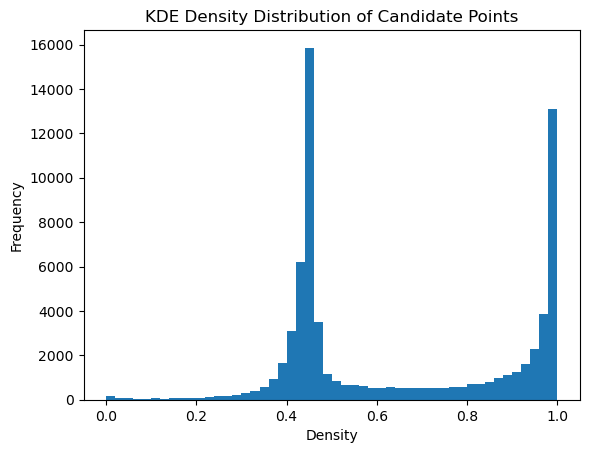

In [36]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(env_scores, bins=50)
plt.title('KDE Density Distribution of Candidate Points')
plt.xlabel('Density')
plt.ylabel('Frequency')
plt.show()

## 特征贡献度解释

## 绘图

In [37]:
## 

# 前期测试

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

# 1. 定义两表共有的特征，用于聚类和建模
feature_cols = [
    'DEM', 'landcover', 'GDPpc', 'GDPtot', 'GURdist', 'Population',
    'Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad',
    'Slope', 'gdmp', 'rsds', 'tas', 'wind'
]

# 假设 df_embedding 和 df_abandon 均已加载
# 2. 标准化处理
scaler = StandardScaler()
X_embed = scaler.fit_transform(df_embedding[feature_cols])
X_abandon = scaler.transform(df_abandon[feature_cols])

# 3. 在 df_embedding 上训练 GMM，选取最佳成分数
bic_scores = []
gmms = []
for k in range(2, 11):
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_embed)
    bic_scores.append(gmm.bic(X_embed))
    gmms.append(gmm)

best_idx = np.argmin(bic_scores)
best_gmm = gmms[best_idx]
print(f"Selected GMM with {best_gmm.n_components} components")

# 4. 获取聚类后验概率（责任度）
resp_embed = best_gmm.predict_proba(X_embed)
resp_abandon = best_gmm.predict_proba(X_abandon)

# 5. 将责任度添加回原 DataFrame
for i in range(best_gmm.n_components):
    df_embedding[f'cluster_prob_{i}'] = resp_embed[:, i]
    df_abandon[f'cluster_prob_{i}'] = resp_abandon[:, i]

# 6. 构造分类数据集
pos_df = df_embedding.copy()
pos_df['label'] = 1
neg_df = df_abandon.copy()
neg_df['label'] = 0

model_df = pd.concat([pos_df, neg_df], ignore_index=True)

# 7. 提取模型特征与标签
cluster_cols = [f'cluster_prob_{i}' for i in range(best_gmm.n_components)]
X = model_df[cluster_cols]
y = model_df['label']

# 8. 划分训练与测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 9. 训练随机森林分类器
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 10. 评估模型性能
y_pred_proba = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print("Test AUC:", auc)
print(classification_report(y_test, clf.predict(X_test)))

# 11. 对所有弃耕记录进行预测
df_abandon['pv_prob'] = clf.predict_proba(df_abandon[cluster_cols])[:, 1]



Selected GMM with 6 components
Test AUC: 0.8769538776858613
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     14126
           1       0.89      0.58      0.70      2100

    accuracy                           0.94     16226
   macro avg       0.92      0.78      0.83     16226
weighted avg       0.93      0.94      0.93     16226



c:\Users\zpy10\Anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\zpy10\Anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\zpy10\Anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\zpy10\Anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25351 (\N{CJK UNIFIED IDEOGRAPH-6307}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\zpy10\Anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26631 (\N{CJK

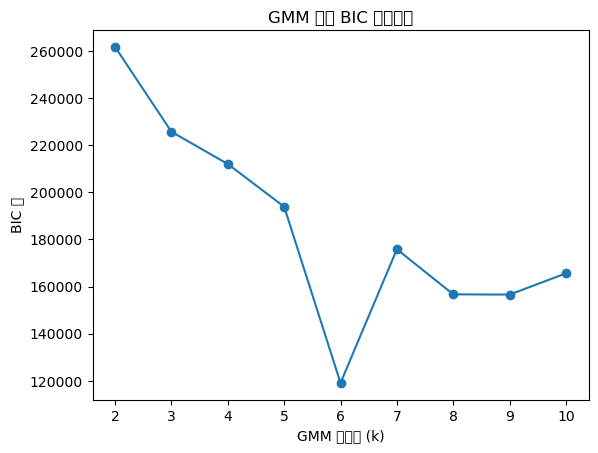

c:\Users\zpy10\Anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32452 (\N{CJK UNIFIED IDEOGRAPH-7EC4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\zpy10\Anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\zpy10\Anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32858 (\N{CJK UNIFIED IDEOGRAPH-805A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\zpy10\Anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\zpy10\Anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21487 (\N{CJK

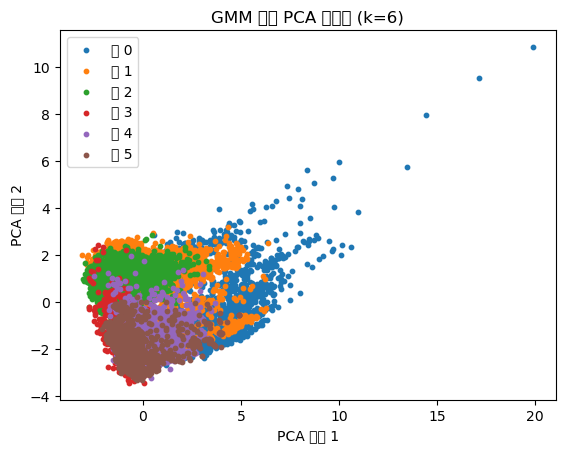

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

# 假设 df_embedding 已加载为 DataFrame
feature_cols = [
    'DEM', 'landcover', 'GDPpc', 'GDPtot', 'GURdist', 'Population',
    'Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad',
    'Slope', 'gdmp', 'rsds', 'tas', 'wind'
]

# 1. 标准化
scaler = StandardScaler()
X_embed = scaler.fit_transform(df_embedding[feature_cols])

# 2. 计算不同成分数的 BIC
ks = range(2, 11)
bic_scores = []
gmms = []
for k in ks:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_embed)
    bic_scores.append(gmm.bic(X_embed))
    gmms.append(gmm)

best_idx = np.argmin(bic_scores)
best_k = ks[best_idx]
best_gmm = gmms[best_idx]

# 3. 绘制 BIC 曲线
plt.figure()
plt.plot(ks, bic_scores, marker='o')
plt.xlabel('GMM 成分数 (k)')
plt.ylabel('BIC 值')
plt.title('GMM 模型 BIC 指标比较')
plt.show()

# 4. PCA 降维至 2 维，并绘制聚类结果散点图
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_embed)
labels = best_gmm.predict(X_embed)

plt.figure()
for lbl in np.unique(labels):
    idx = labels == lbl
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f'簇 {lbl}', s=10)
plt.xlabel('PCA 组件 1')
plt.ylabel('PCA 组件 2')
plt.title(f'GMM 聚类 PCA 可视化 (k={best_k})')
plt.legend()
plt.show()


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

# 假设 df_embedding 和 df_abandon 已加载，且包含 cluster_prob_* 列
cluster_cols = [c for c in df_embedding.columns if c.startswith('cluster_prob_')]

# 构造正负样本
pos = df_embedding.copy()
pos['label'] = 1
neg = df_abandon.copy()
neg['label'] = 0

data = pd.concat([pos, neg], ignore_index=True)
X = data[cluster_cols]
y = data['label']

# 划分数据集并训练
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_prob = clf.predict_proba(X_test)[:, 1]

# 1. 绘制 ROC 曲线
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {roc_auc:.3f})')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 2. 绘制特征重要性
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
feat_names = np.array(cluster_cols)[indices]

plt.figure()
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), feat_names, rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()


KeyboardInterrupt: 